In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
from SSA import SSA

from sklearn.metrics import mean_absolute_percentage_error

plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
ts = pd.read_csv('beer_production.csv')['Monthly beer production'].to_numpy()
plt.plot(ts);

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class LRF():
    def __init__(self, dim = None, max_dim = None, validation_size = 0.05):
        self.dim = dim
        self.max_dim = max_dim
        self.validation_size = validation_size

    def fit(self, X):
        '''
        X - series vector (1, n)
        '''
        validation_size = int(self.validation_size * X.shape[0])
        stop_index = X.shape[0] - validation_size

        initial_mse = np.inf
        if not self.dim:
            for dim in range(3,X.shape[0] // 2 + 10, 5):
                self.dim = dim

                X_train = np.vstack([X[i:dim+i] for i in range(stop_index - dim )])
                y_train = np.stack([X[dim + i] for i in range(stop_index - dim )])

                y_validation = np.stack([X[stop_index + i] for i in range(validation_size)])

                regressor = LinearRegression(fit_intercept = False)
                regressor.fit(X_train, y_train)

                self.weights = regressor.coef_

                predictions = self.predict(X_train[-1, :], M = validation_size)
                mse_score = mean_squared_error(y_validation, predictions)
                if mse_score < initial_mse:
                    self.best_dim = dim
                    self.best_weights = self.weights
                    initial_mse = mse_score
            self.dim = self.best_dim
            self.weights = self.best_weights

        else:
            X_train = np.vstack([X[i:self.dim+i] for i in range(stop_index - self.dim )])
            y_train = np.stack([X[self.dim + i] for i in range(stop_index - self.dim )])
            regressor = LinearRegression(fit_intercept = False)
            regressor.fit(X_train, y_train)

            self.weights = regressor.coef_



    def predict(self, X, M):
        '''
        X - series vector (1, n), n >= dim
        M - number of points to predict
        '''
        for i in range(M):
            last_prediction = self.weights @ X[-self.dim:]
            X = np.concatenate([X, [last_prediction]])

        predictions = X[-M:]
        return predictions







MAPE:  11.38 %
Best dim:  38


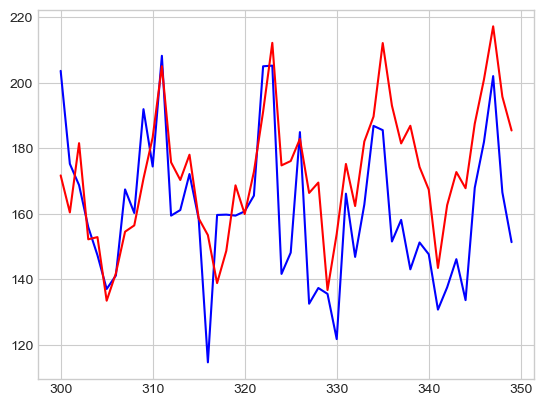

In [ ]:
train_data = ts[:300]
test_data = ts[300:350]

lrf = LRF()
lrf.fit(train_data)
preds = lrf.predict(train_data, M = 50)
mape = mean_absolute_percentage_error(test_data, preds)

print('MAPE: ', round(mape*100,2), '%')
print('Best dim: ', lrf.best_dim)

#plt.plot(range(300), train_data, c = 'blue')
plt.plot(range(300,350), test_data, c = 'blue')
plt.plot(range(300,350), preds, color='red'); # валидационную часть лучше делать поменьше


In [4]:
import torch.nn as nn

class CNNPredictor(nn.Module):
    def __init__(self, rank, n=1000, l=400, kernel_size = 3):
        '''
        n: int - dimensionality of time series
        l: int - window lengt
        rank: int - rank of trajectory tensor (if 1, it is initial trajectory matrix)
        kernel_size: int, (int x int) - kernel size of convolution layers

        '''
        super(RLRF, self).__init__()
        self.kernel_size = 3

        self.conv1 = nn.conv2d(in_features = rank, out_features = 2*rank, kernel_size = self.kernel_size)
        self.conv2 = nn.conv2d(in_features = 2*rank, out_features = 4*rank, kernel_size = self.kernel_size)
        self.conv3 = nn.conv2d(in_features = 4*rank, out_features = rank*2**3, kernel_size = self.kernel_size)
        self.linear = nn.Linear(rank*2**3 * (l - 6)*(n-l-5), 1)

        self.batchnorm1 = nn.BatchNorm2d(2*rank)
        self.batchnorm2 = nn.BatchNorm2d(4*rank)
        self.batchnorm3 = nn.BatchNorm2d(8*rank)


    def forward(self,X):
        # first block
        a = nn.functional.max_pool2d(self.batchnorm1(self.conv1(X)), kernel_size = self.kernel_size)
        a = nn.functional.relu(a)
        # second block
        a = nn.functional.max_pool2d(self.batchnorm2(self.conv2(X)), kernel_size = self.kernel_size)
        a = nn.functional.relu(a)
        # third block
        a = self.batchnorm3(self.conv3(a))
        a = nn.functional.relu(a)
        # head
        a = nn.flatten(a)
        a = self.linear(a)

        return a

OSError: [WinError 127] Не найдена указанная процедура. Error loading "D:\conda\envs\new_env\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [3]:
# import torch.nn as nn

# class RLRF(nn.Module):
#     def __init__(self, l):
#         super(RLRF, self).__init__()
#         self.l = l





